## Лабораторна робота 2 з ІСППР (варіант 22)
### Виконали студенти групи КІ-31мп Шабо О.А. та Сотник Д.C.
##### Датасет: https://www.kaggle.com/datasets/rahulsah06/gooogle-stock-pricedf_test.head()

In [55]:
import torch
import random
import gc
import os

import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import itertools as it

from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.optim import Adam

In [56]:
if torch.cuda.is_available():
    print("PyTorch GPU is available")
else:
    print("PyTorch GPU is not available")
DEVICE = "cuda"

PyTorch GPU is available


In [57]:
RANDOM_SEED = 10

# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(RANDOM_SEED)
# Set python seed
random.seed(RANDOM_SEED)
# Set numpy seed
np.random.seed(RANDOM_SEED)

torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator().manual_seed(RANDOM_SEED)

In [58]:
df_train = pd.read_csv('/kaggle/input/gooogle-stock-price/Google_Stock_Price_Train.csv')
df_train.tail()

,Date,Open,High,Low,Close,Volume
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"
1257,12/30/2016,782.75,782.78,770.41,771.82,"1,770,000"


In [59]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [60]:
df_test = pd.read_csv('/kaggle/input/gooogle-stock-price/Google_Stock_Price_Test.csv')
df_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [61]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [62]:
df_train['Close'] = pd.to_numeric(df_train['Close'].str.replace(',', ''), errors='coerce')
df = pd.concat([df_train, df_test], axis=0)

In [63]:
# Select features and target for modeling
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Volume'] = pd.to_numeric(df['Volume'].str.replace(',', ''), errors='coerce')

features = df[['Open', 'High', 'Low', 'Volume']]
target = df['Close'].to_frame()

# Normalize features
feature_scaler = StandardScaler()
target_scaler = deepcopy(feature_scaler)
split_index = int(len(df) * 0.75)
feature_scaler.fit(features.head(split_index)) # we have access only to train set
target_scaler.fit(target.head(split_index)) # we have access only to train set
features_normalized = feature_scaler.transform(features)
target_normalized = target_scaler.transform(target)

# Split the data
X_train = features_normalized[:split_index]
y_train = target_normalized[:split_index]
X_test = features_normalized[split_index:]
y_test = target_normalized[split_index:]

In [64]:
INPUT_SEQUENCE = 14  # For example, use 5 days of data to predict
OUTPUT_SEQUENCE = 10  # Predict the next 10 days 

# Function to create dataset with sequences
def create_sequences(features, target, input_sequence, output_sequence):
    X = []
    y = []

    for i in range(len(features) - input_sequence - output_sequence + 1):
        X.append(features[i:(i + input_sequence)])
        y.append(target[(i + input_sequence):(i + input_sequence + output_sequence)])
    
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train, y_train, INPUT_SEQUENCE, OUTPUT_SEQUENCE)
X_test, y_test = create_sequences(X_test, y_test, INPUT_SEQUENCE, OUTPUT_SEQUENCE)


# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [78]:
features_normalized.shape[0]

1278

In [65]:
X_train_tensor.shape

torch.Size([935, 14, 4])

In [66]:
X_test_tensor.shape

torch.Size([297, 14, 4])

In [67]:
y_train_tensor.shape

torch.Size([935, 10, 1])

In [68]:
y_test_tensor.shape

torch.Size([297, 10, 1])

In [69]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [70]:
class BasicRNN():
    def fit(self, X_train, y_train, X_test, y_test, learning_rate=0.01,
            num_epochs=100, batch_size=32, verbose=True, optimizer_class=Adam,
            loss_fn=nn.MSELoss):
        optimizer = optimizer_class(self.parameters(), lr=learning_rate)
        criterion = loss_fn()

        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)

        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

        train_losses = []
        test_losses = []

        for epoch in tqdm(range(num_epochs), disable=not verbose):
            self.train()
            train_loss = 0.0
            best_test_loss = np.inf
            best_model = None
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                optimizer.zero_grad()
                outputs = self(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()  # Correct loss calculation
            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)
            test_loss = self.evaluate(test_loader, criterion)
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model = deepcopy(self)
            test_losses.append(test_loss)

            if verbose and (epoch+1) % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        self.train_losses = train_losses
        self.test_losses = test_losses
        best_model.train_losses = np.copy(train_losses)
        best_model.test_losses = np.copy(test_losses)
        gc.collect()
        return best_model, best_test_loss

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()
        plt.show()

    def evaluate(self, data_loader, criterion):
        self.eval()
        total_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in data_loader:
                X_batch = X_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                outputs = self(X_batch)
                loss = criterion(outputs, y_batch)
                total_loss += loss.item()  # Correct loss calculation
        return total_loss / len(data_loader.dataset)
    

In [71]:
class RNNModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        # Adjust output dimension to account for output_sequence
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        # Assume x is already shaped as (batch, input_sequence, features)
        self.rnn.flatten_parameters()  # Optimize for GPU
        out, _ = self.rnn(x)
        # Reshape the output to fit into the fully connected layer
        out = out[:, -1, :]  # Taking the output of the last time step
        out = self.fc(out)
        # Reshape the output to have the output_sequence in the last dimension
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out

    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size = params
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = RNNModel(
                input_dim=X_train.shape[-1], hidden_dim=hidden_dim, output_dim=y_train.shape[-1], 
                input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE
            ).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, batch_size=batch_size, learning_rate=lr, verbose=False)

#             test_dataset = TensorDataset(X_test, y_test)
#             test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
#             val_loss = model.evaluate(test_loader, criterion)

            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [72]:
# parameter_grid = {
#     'lr': [0.1, 0.01],
#     'hidden_dim': [25, 50, 75, 100],
#     'batch_size': [64]
# }
parameter_grid = {
    'lr': [0.001],
    'hidden_dim': [25, 50, 75, 100],
    'batch_size': [64]
}

(best_rnn_params, best_rnn_model) = RNNModel.find_best_parameters(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, parameter_grid)

  0%|          | 0/4 [00:00<?, ?it/s]

Best parameters found: (0.001, 25, 64), with validation loss: 0.0002687360577109687


In [73]:
# best_rnn_model.fit(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs=1000, learning_rate=best_rnn_params[0], batch_size=best_rnn_params[2])

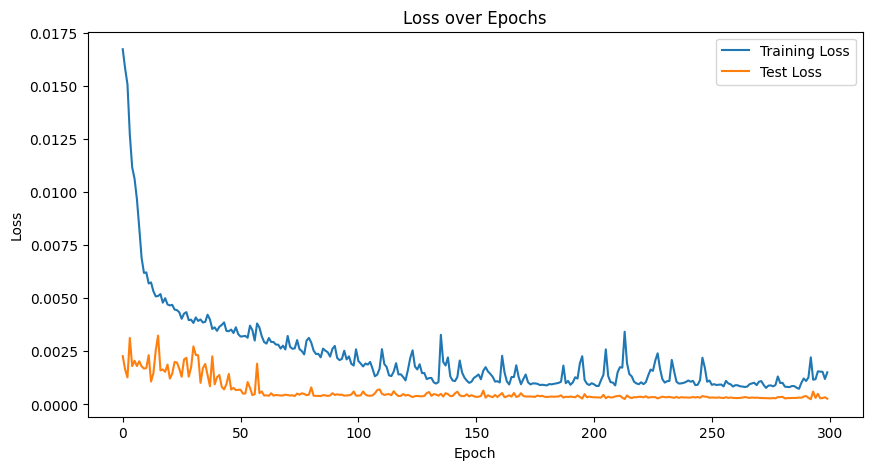

In [74]:
best_rnn_model.plot_loss()

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def metrics(model):
    y_pred_test = model(X_test_tensor.to(DEVICE)).detach().cpu().numpy()
    y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

    # Перетворення передбачень з нормалізованого вигляду назад до оригінальних значень
    y_pred_test_unscaled = target_scaler.inverse_transform(y_pred_test.reshape(-1, 1))

    # Обчислення RMSE
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_test_unscaled))

    # Обчислення MAE
    mae = mean_absolute_error(y_test_actual, y_pred_test_unscaled)

    # Обчислення MAPE
    mape = np.mean(np.abs((y_test_actual - y_pred_test_unscaled) / y_test_actual)) * 100

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}%")
    
    
metrics(best_rnn_model)

RMSE: 23.995520851171726
MAE: 18.524128137659144
MAPE: 2.509471608072477%


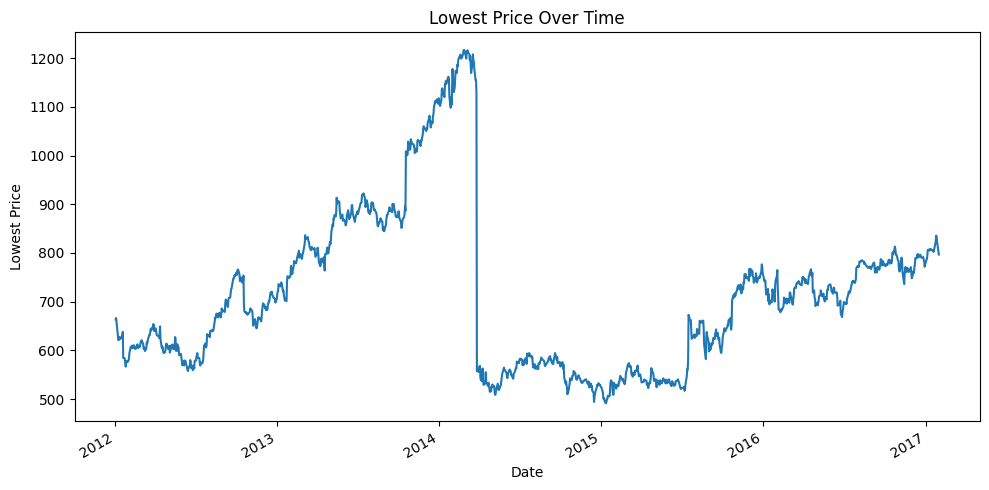

In [76]:
# Plot 'Avg' over time
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Close'], label='Lowest Price')
plt.xlabel("Date")
plt.ylabel("Lowest Price")
plt.title("Lowest Price Over Time")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

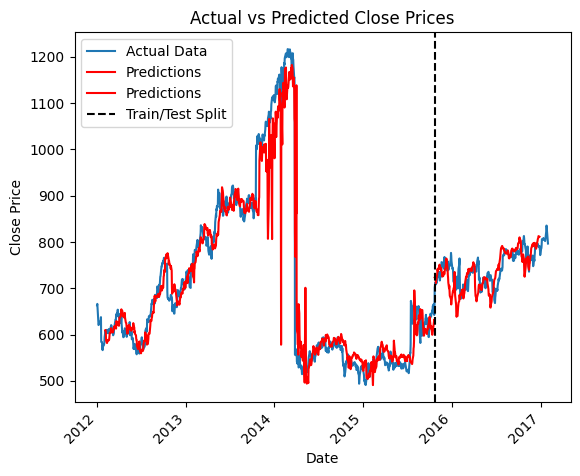

In [88]:
def plot_data_and_prediction(model, features_scaler, target_scaler, split_index, input_sequence, output_sequence, xticks_data=df['Date'].values, yticks_data=df['Close'].values, features_data=df.drop(['Date', 'Close'], axis=1),):
    _, ax = plt.subplots()
    # Plot real data
    ax.plot(xticks_data, yticks_data, label='Actual Data')
    
    # Prepare to plot predicted data
    # Note: Adjust your model prediction and data preparation as necessary


    # Assuming X_train_tensor and X_test_tensor are globally accessible; adjust as necessary
    for tensor, is_train in [(X_train_tensor, True), (X_test_tensor, False)]:
        predictions = []  # This will store all your predictions
        prediction_dates = []  # This will store corresponding dates for predictions
        # Generate predictions
        y_pred_tensor = model.forward(tensor.to(DEVICE)).detach()
        y_pred_unscaled = target_scaler.inverse_transform(y_pred_tensor.cpu().numpy().reshape(-1, 1)).flatten()

        # Since the predictions may not cover every date (especially with output sequences), you might need to adjust this part
        # Here we're plotting the last day of each predicted sequence for simplicity
        start_idx = split_index if not is_train else 0 + input_sequence + output_sequence - 1
        ax.plot(xticks_data[start_idx:start_idx+tensor.shape[0]],\
                [y_pred_unscaled[(i + 1) * output_sequence - 1] for i in range(tensor.shape[0])],
                'r', label='Predictions')

    # Additional plot formatting
    plt.axvline(x=xticks_data[split_index], color='black', linestyle='--', label='Train/Test Split')
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")
    ax.set_title('Actual vs Predicted Close Prices')
    plt.legend()
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
    plt.show()

# Call your plot function with the appropriate parameters
plot_data_and_prediction(model=best_rnn_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

In [25]:
class LSTMModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        x = x.view(-1, self.input_sequence, x.size(-1))  # Ensure input is (batch, sequence, features)
        self.lstm.flatten_parameters()
        out, (h_n, c_n) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out
    
    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size = params
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = LSTMModel(
                input_dim=X_train.shape[-1], hidden_dim=hidden_dim, output_dim=y_train.shape[-1], 
                input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE
            ).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, batch_size=batch_size, learning_rate=lr, verbose=False)

#             test_dataset = TensorDataset(X_test, y_test)
#             test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
#             val_loss = model.evaluate(test_loader, criterion)

            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)
                
        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [27]:
parameter_grid = {
    'lr': [0.1, 0.01, 0.001],
    'hidden_dim': [25, 50, 75, 100],
    'batch_size': [32, 64]
}
# parameter_grid = {
#     'lr': [0.001],
#     'hidden_dim': [25],
#     'batch_size': [64]
# }

(best_lstm_params, best_lstm_model) = LSTMModel.find_best_parameters(
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor, 
    parameter_grid)

  0%|          | 0/24 [00:00<?, ?it/s]

Best parameters found: (0.001, 50, 64), with validation loss: 0.0031607513526072007


In [ ]:
# best_lstm_model.fit(X_train_tensor, y_train_tensor, 
#                     X_test_tensor, y_test_tensor, 
#                     num_epochs=1000, 
#                     learning_rate=best_lstm_params[0], 
#                     batch_size=best_lstm_params[2])

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10/1000, Training Loss: 0.0004, Test Loss: 0.0020

Epoch 20/1000, Training Loss: 0.0025, Test Loss: 0.0036

Epoch 30/1000, Training Loss: 0.0004, Test Loss: 0.0019

Epoch 40/1000, Training Loss: 0.0005, Test Loss: 0.0016

Epoch 50/1000, Training Loss: 0.0002, Test Loss: 0.0017

Epoch 60/1000, Training Loss: 0.0002, Test Loss: 0.0018

Epoch 70/1000, Training Loss: 0.0003, Test Loss: 0.0021

Epoch 80/1000, Training Loss: 0.0011, Test Loss: 0.0025

Epoch 90/1000, Training Loss: 0.0002, Test Loss: 0.0019

Epoch 100/1000, Training Loss: 0.0002, Test Loss: 0.0022

Epoch 110/1000, Training Loss: 0.0002, Test Loss: 0.0022

Epoch 120/1000, Training Loss: 0.0002, Test Loss: 0.0027

Epoch 130/1000, Training Loss: 0.0002, Test Loss: 0.0027

Epoch 140/1000, Training Loss: 0.0001, Test Loss: 0.0023

Epoch 150/1000, Training Loss: 0.0005, Test Loss: 0.0014

Epoch 160/1000, Training Loss: 0.0002, Test Loss: 0.0016

Epoch 170/1000, Training Loss: 0.0001, Test Loss: 0.0014

Epoch 180/1000, Trainin

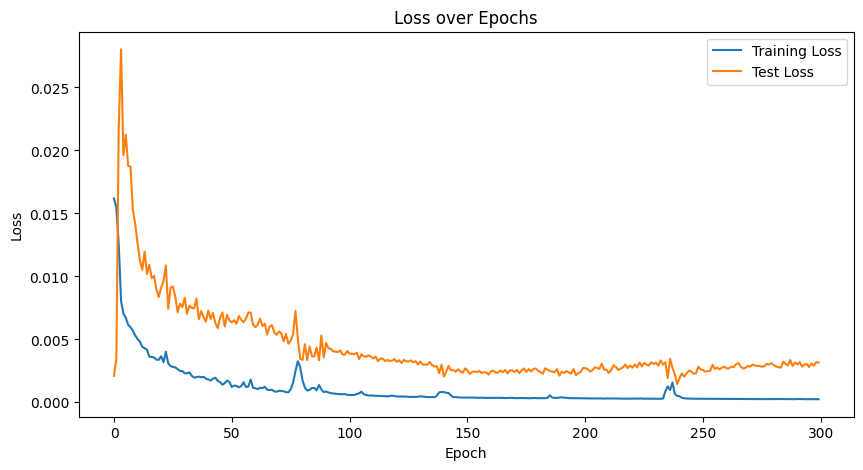

In [28]:
best_lstm_model.plot_loss()

In [29]:
metrics(best_lstm_model)

RMSE: 78.90120461362932
MAE: 73.14886222906144
MAPE: 9.63576745966208%


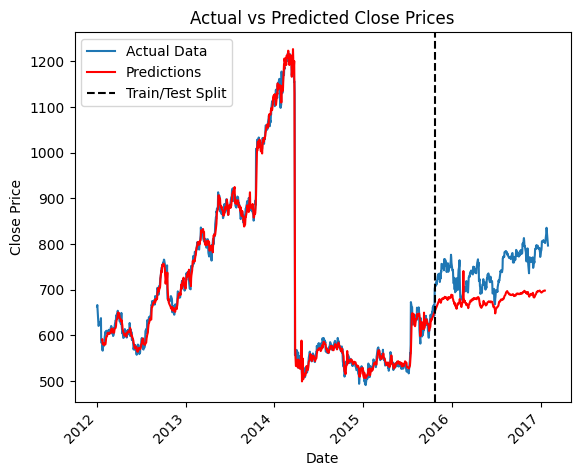

In [30]:
plot_data_and_prediction(model=best_lstm_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

In [31]:
class GRUModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)  # Use GRU instead of RNN
        # Adjust output dimension to account for output_sequence
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        # Assume x is already shaped as (batch, input_sequence, features)
        out, _ = self.gru(x)  # Process input through the GRU layer
        # Reshape the output to fit into the fully connected layer
        out = out[:, -1, :]  # Taking the output of the last time step
        out = self.fc(out)
        # Reshape the output to have the output_sequence in the last dimension
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out
    
    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size = params
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = GRUModel(
                input_dim=X_train.shape[-1], hidden_dim=hidden_dim, output_dim=y_train.shape[-1], 
                input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE
            ).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, batch_size=batch_size, learning_rate=lr, verbose=False)

#             test_dataset = TensorDataset(X_test, y_test)
#             test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
#             val_loss = model.evaluate(test_loader, criterion)

            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [32]:
parameter_grid = {
    'lr': [0.1, 0.01, 0.001],
    'hidden_dim': [5, 10, 15, 25],
    'batch_size': [32, 64]
}
# parameter_grid = {
#     'lr': [0.01],
#     'hidden_dim': [10],
#     'batch_size': [64]
# }

(best_gru_params, best_gru_model) = GRUModel.find_best_parameters(
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor, 
    parameter_grid)

  0%|          | 0/24 [00:00<?, ?it/s]

Best parameters found: (0.001, 5, 64), with validation loss: 0.001920388679111044


In [ ]:
# best_gru_model.fit(X_train_tensor, y_train_tensor, 
#                     X_test_tensor, y_test_tensor, 
#                     num_epochs=300, 
#                     learning_rate=best_gru_params[0], 
#                     batch_size=best_gru_params[2])

  0%|          | 0/300 [00:00<?, ?it/s]

c:\Users\Dmytro Sotnyk\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)

  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch 10/300, Training Loss: 0.0002, Test Loss: 0.0054

Epoch 20/300, Training Loss: 0.0002, Test Loss: 0.0046

Epoch 30/300, Training Loss: 0.0007, Test Loss: 0.0036

Epoch 40/300, Training Loss: 0.0011, Test Loss: 0.0079

Epoch 50/300, Training Loss: 0.0002, Test Loss: 0.0038

Epoch 60/300, Training Loss: 0.0002, Test Loss: 0.0037

Epoch 70/300, Training Loss: 0.0002, Test Loss: 0.0044

Epoch 80/300, Training Loss: 0.0002, Test Loss: 0.0043

Epoch 90/300, Training Loss: 0.0002, Test Loss: 0.0035

Epoch 100/300, Training Loss: 0.0002, Test Loss: 0.0073

Epoch 110/300, Training Loss: 0.0005, Test Loss: 0.0086

Epoch 120/300, Training Loss: 0.0002, Test Loss: 0.0102

Epoch 130/300, Training Loss: 0.0002, Test Loss: 0.0056

Epoch 140/300, Training Loss: 0.0002, Test Loss: 0.0054

Epoch 150/300, Training Loss: 0.0001, Test Loss: 0.0053

Epoch 160/300, Training Loss: 0.0001, Test Loss: 0.0054

Epoch 170/300, Training Loss: 0.0016, Test Loss: 0.0078

Epoch 180/300, Training Loss: 0.0002, Te

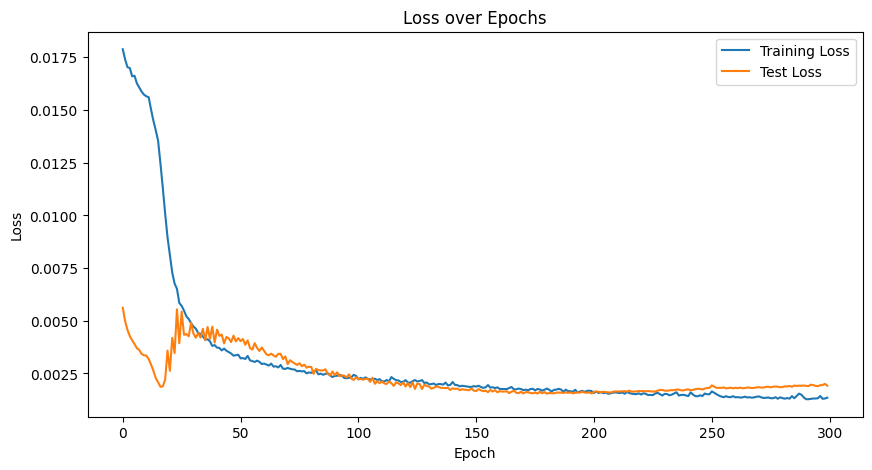

In [33]:
best_gru_model.plot_loss()

In [34]:
metrics(best_gru_model)

RMSE: 63.17167159365543
MAE: 50.56180641374685
MAPE: 6.735916157932966%


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


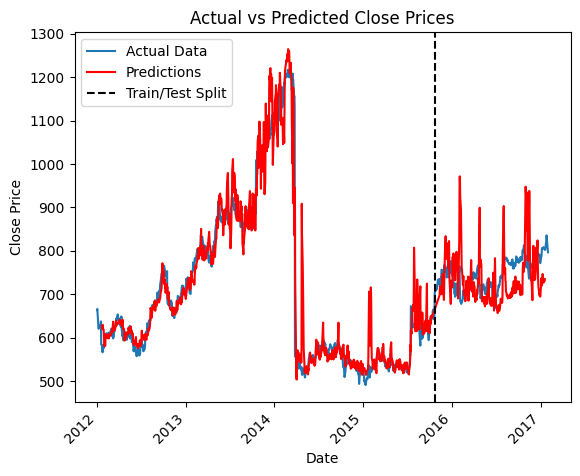

In [36]:
plot_data_and_prediction(model=best_gru_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

## Моделі із декількома шарами

In [37]:
class LSTMDeepModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence, num_layers=2):
        super(LSTMDeepModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        x = x.view(-1, self.input_sequence, x.size(-1))  # Ensure input is (batch, sequence, features)
        self.lstm.flatten_parameters()
        out, (h_n, c_n) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out
    
    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size, num_layers = params  # Include num_layers in the parameter grid
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = LSTMDeepModel(
                input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                num_layers=num_layers, input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, 
                      batch_size=batch_size, learning_rate=lr, verbose=False)

#             test_dataset = TensorDataset(X_test, y_test)
#             test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
#             val_loss = model.evaluate(test_loader, criterion)

            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [46]:
parameter_grid = {
    'lr': [0.05, 0.01, 0.005],
    'hidden_dim': [10, 25, 35],
    'batch_size': [64],
    'layers': [2, 3, 4]
}
# parameter_grid = {
#     'lr': [0.1],
#     'hidden_dim': [50],
#     'batch_size': [64],
#     'layers': [3]
# }

(best_lstm_deep_params, best_lstm_deep_model) = LSTMDeepModel.find_best_parameters(
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor, 
    parameter_grid)

  0%|          | 0/27 [00:00<?, ?it/s]

Best parameters found: (0.005, 25, 64, 3), with validation loss: 0.004219971321247242


In [ ]:
# best_lstm_deep_model.fit(X_train_tensor, y_train_tensor, 
#                     X_test_tensor, y_test_tensor, 
#                     num_epochs=1000, 
#                     learning_rate=best_lstm_params[0], 
#                     batch_size=best_lstm_params[2])

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10/1000, Training Loss: 0.0110, Test Loss: 0.0129

Epoch 20/1000, Training Loss: 0.0104, Test Loss: 0.0126

Epoch 30/1000, Training Loss: 0.0102, Test Loss: 0.0115

Epoch 40/1000, Training Loss: 0.0091, Test Loss: 0.0100

Epoch 50/1000, Training Loss: 0.0087, Test Loss: 0.0098

Epoch 60/1000, Training Loss: 0.0081, Test Loss: 0.0095

Epoch 70/1000, Training Loss: 0.0072, Test Loss: 0.0109

Epoch 80/1000, Training Loss: 0.0065, Test Loss: 0.0113

Epoch 90/1000, Training Loss: 0.0061, Test Loss: 0.0125

Epoch 100/1000, Training Loss: 0.0054, Test Loss: 0.0143

Epoch 110/1000, Training Loss: 0.0048, Test Loss: 0.0172

Epoch 120/1000, Training Loss: 0.0044, Test Loss: 0.0213

Epoch 130/1000, Training Loss: 0.0038, Test Loss: 0.0225

Epoch 140/1000, Training Loss: 0.0034, Test Loss: 0.0231

Epoch 150/1000, Training Loss: 0.0031, Test Loss: 0.0232

Epoch 160/1000, Training Loss: 0.0028, Test Loss: 0.0232

Epoch 170/1000, Training Loss: 0.0029, Test Loss: 0.0218

Epoch 180/1000, Trainin

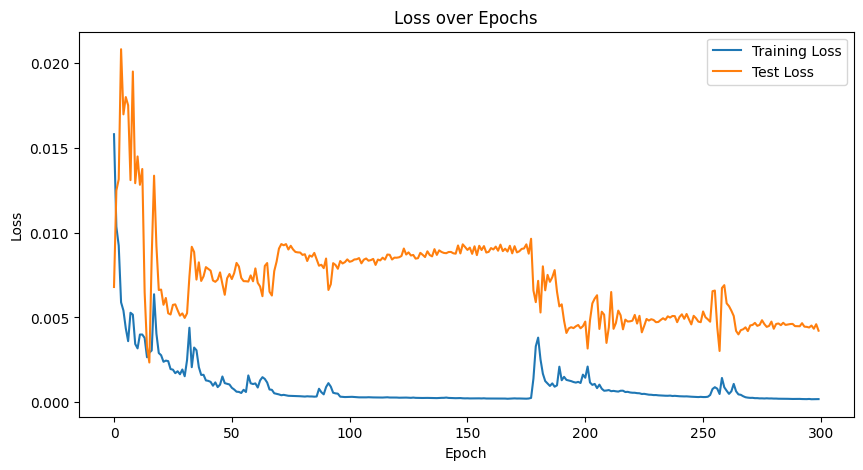

In [47]:
best_lstm_deep_model.plot_loss()

In [48]:
metrics(best_lstm_deep_model)

RMSE: 90.93143244301312
MAE: 83.55003738804055
MAPE: 10.995873889959789%


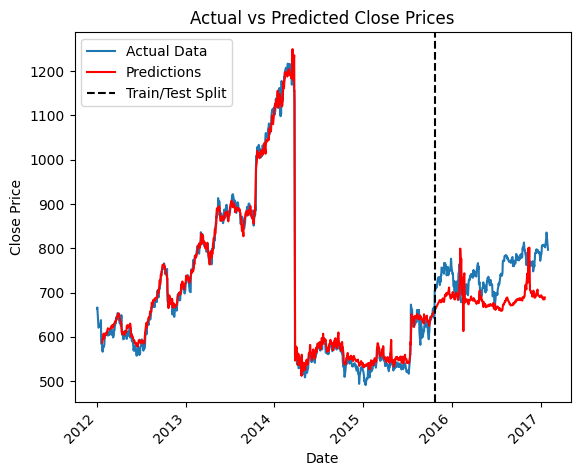

In [49]:
plot_data_and_prediction(model=best_lstm_deep_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

In [50]:
class GRUDeepModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence, num_layers=2):
        super(GRUDeepModel, self).__init__()
        # Set up a deep GRU with specified number of layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        # Assume x is already shaped as (batch, input_sequence, features)
        out, _ = self.gru(x)  # Process input through the GRU layer
        # Reshape the output to fit into the fully connected layer
        out = out[:, -1, :]  # Taking the output of the last time step
        out = self.fc(out)
        # Reshape the output to have the output_sequence in the last dimension
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out
    
    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size, num_layers = params  # Include num_layers in the parameter grid
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = GRUDeepModel(
                input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                num_layers=num_layers, input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE
            ).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, 
                      batch_size=batch_size, learning_rate=lr, verbose=False)

#             test_dataset = TensorDataset(X_test, y_test)
#             test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
#             val_loss = model.evaluate(test_loader, criterion)

            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [51]:
parameter_grid = {
    'lr': [0.05, 0.01, 0.005],
    'hidden_dim': [10, 25, 35],
    'batch_size': [64],
    'layers': [2, 3, 4]
}

(best_gru_deep_params, best_gru_deep_model) = GRUDeepModel.find_best_parameters(
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor, 
    parameter_grid)

  0%|          | 0/27 [00:00<?, ?it/s]

Best parameters found: (0.005, 10, 64, 3), with validation loss: 0.0033711657831163116


In [ ]:
# best_gru_deep_model.fit(X_train_tensor, y_train_tensor, 
#                     X_test_tensor, y_test_tensor, 
#                     num_epochs=1000, 
#                     learning_rate=best_gru_deep_params[0], 
#                     batch_size=best_gru_deep_params[2])

  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\Dmytro Sotnyk\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)

  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch 10/1000, Training Loss: 0.0134, Test Loss: 0.0116

Epoch 20/1000, Training Loss: 0.0173, Test Loss: 0.0026

Epoch 30/1000, Training Loss: 0.0190, Test Loss: 0.0027

Epoch 40/1000, Training Loss: 0.0171, Test Loss: 0.0009

Epoch 50/1000, Training Loss: 0.0171, Test Loss: 0.0012

Epoch 60/1000, Training Loss: 0.0167, Test Loss: 0.0039

Epoch 70/1000, Training Loss: 0.0167, Test Loss: 0.0006

Epoch 80/1000, Training Loss: 0.0164, Test Loss: 0.0021

Epoch 90/1000, Training Loss: 0.0204, Test Loss: 0.0160

Epoch 100/1000, Training Loss: 0.0173, Test Loss: 0.0033

Epoch 110/1000, Training Loss: 0.0178, Test Loss: 0.0009

Epoch 120/1000, Training Loss: 0.0174, Test Loss: 0.0019

Epoch 130/1000, Training Loss: 0.0172, Test Loss: 0.0035

Epoch 140/1000, Training Loss: 0.0167, Test Loss: 0.0015

Epoch 150/1000, Training Loss: 0.0163, Test Loss: 0.0026

Epoch 160/1000, Training Loss: 0.0161, Test Loss: 0.0036

Epoch 170/1000, Training Loss: 0.0164, Test Loss: 0.0035

Epoch 180/1000, Trainin

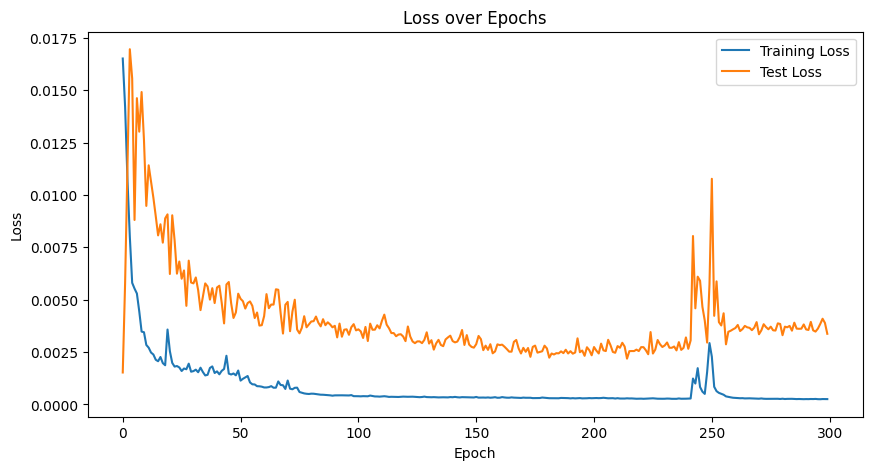

In [52]:
best_gru_deep_model.plot_loss()

In [53]:
metrics(best_gru_deep_model)

RMSE: 81.33240485048601
MAE: 72.31778119328045
MAPE: 9.500902050185717%


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


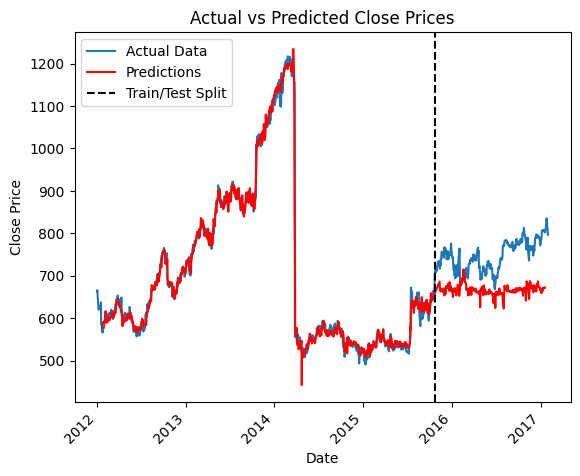

In [54]:
plot_data_and_prediction(model=best_gru_deep_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

## Моделі із дропаутами

In [240]:
class LSTMDropoutModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence, num_layers=2, dropout_rate=0.5):
        super(LSTMDropoutModel, self).__init__()
        # Include dropout_rate in the LSTM layer, dropout is applied between LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        x = x.view(-1, self.input_sequence, x.size(-1))  # Ensure input is (batch, sequence, features)
        self.lstm.flatten_parameters()
        out, (h_n, c_n) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out
    
    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size, num_layers, dropout_rate = params  # Include num_layers in the parameter grid
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = LSTMDropoutModel(
                input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                num_layers=num_layers, input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE,
                dropout_rate=dropout_rate
            ).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, 
                      batch_size=batch_size, learning_rate=lr, verbose=False)

#             test_dataset = TensorDataset(X_test, y_test)
#             test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
#             val_loss = model.evaluate(test_loader, criterion)

            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)
                
        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [241]:
parameter_grid = {
    'lr': [0.05, 0.01],
    'hidden_dim': [7, 17],
    'batch_size': [64],
    'layers': [2, 3, 4],
    'dropout_rate': [0.4, 0.5, 0.6]
}

(best_lstm_drp_params, best_lstm_drp_model) = LSTMDropoutModel.find_best_parameters(
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor, 
    parameter_grid)

  0%|          | 0/144 [00:00<?, ?it/s]

In [ ]:
# best_lstm_drp_model.fit(X_train_tensor, y_train_tensor, 
#                     X_test_tensor, y_test_tensor, 
#                     num_epochs=1000, 
#                     learning_rate=best_lstm_drp_params[0], 
#                     batch_size=best_lstm_drp_params[2])

In [ ]:
best_lstm_drp_model.plot_loss()

In [ ]:
metrics(best_lstm_drp_model)

In [ ]:
plot_data_and_prediction(model=best_lstm_drp_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

In [ ]:
class GRUDropoutModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence, num_layers=2, dropout_rate=0.5):
        super(GRUDropoutModel, self).__init__()
        # Set up a deep GRU with specified number of layers and dropout
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        # Assume x is already shaped as (batch, input_sequence, features)
        out, _ = self.gru(x)  # Process input through the GRU layer
        # Reshape the output to fit into the fully connected layer
        out = out[:, -1, :]  # Taking the output of the last time step
        out = self.fc(out)
        # Reshape the output to have the output_sequence in the last dimension
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out
    
    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size, num_layers, dropout_rate = params  # Include num_layers in the parameter grid
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = GRUDropoutModel(
                input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                num_layers=num_layers, input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE,
                dropout_rate=dropout_rate
            ).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, 
                      batch_size=batch_size, learning_rate=lr, verbose=False)

#             test_dataset = TensorDataset(X_test, y_test)
#             test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
#             val_loss = model.evaluate(test_loader, criterion)

            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [ ]:
parameter_grid = {
    'lr': [0.05, 0.01],
    'hidden_dim': [7, 17],
    'batch_size': [64],
    'layers': [2, 3, 4],
    'dropout_rate': [0.4, 0.5, 0.6]
}

(best_gru_drp_params, best_gru_drp_model) = GRUDropoutModel.find_best_parameters(
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor, 
    parameter_grid)

In [ ]:
# best_gru_drp_model.fit(X_train_tensor, y_train_tensor, 
#                     X_test_tensor, y_test_tensor, 
#                     num_epochs=1000, 
#                     learning_rate=best_gru_drp_params[0], 
#                     batch_size=best_gru_drp_params[2])

In [ ]:
best_gru_drp_model.plot_loss()

In [ ]:
metrics(best_gru_drp_model)

In [ ]:
plot_data_and_prediction(model=best_gru_drp_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)